In [5]:
import regex as re
from collections import defaultdict
import time
from scipy.sparse import *

import numpy as np
from sklearn.svm import SVC
from tqdm import tqdm
import os 
import glob
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import *
import json
import matplotlib.pyplot as plt
import pickle
%matplotlib inline



import sys
sys.path.insert(1, '../src')
import make_dataset
import model 
import build_features
import multi_kernel




plt.style.use('seaborn-whitegrid')

In [6]:
import importlib
importlib.reload(make_dataset)
importlib.reload(build_features)
importlib.reload(model)

<module 'model' from '../src/model.py'>

In [7]:
train_created = True

dir_list = '../test-data'
benign_paths = make_dataset.benign_app_paths_test(dir_list)[:2]

with open('../test-data/processed/app_to_api.json') as f:
    apps_dic = json.loads(f.read())
    f.close()
print('apps_dic Loaded')
with open('../test-data/processed/code_block.json') as f:
    code_block_dic = json.loads(f.read())
    f.close()
print('code_block_dic Loaded')
with open('../test-data/processed/library_dic.json') as f:
    package_dic = json.loads(f.read())
    f.close()
print('package_dic Loaded')

api_path = '../test-data/processed/unique_api.text'
with open(api_path, "rb") as fp: 
    api_list = pickle.load(fp)

app_list = list(apps_dic.keys())

apps_dic Loaded
code_block_dic Loaded
package_dic Loaded


## EDA

In [8]:
## Mean API's in all apps
average_apps = [len(set(apps_dic[key])) for key in apps_dic.keys()]
np.mean(average_apps)

4156.2

In [9]:
mean_benign = np.mean(average_apps[:1104])
print(str(mean_benign)+' mean number of APIs for Benign apps')


4156.2 mean number of APIs for Benign apps


In [10]:
mean_malware = np.mean(average_apps[1104:])
print(str(mean_malware)+' mean number of APIs for Malware apps')

nan mean number of APIs for Malware apps


/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [11]:
## Most common API's in Benign apps with counts 

In [12]:
benign_api_count = defaultdict(int)
benign_api = set()
benign_apps  = [i.split('/')[-1] for i in  benign_paths]
for key in apps_dic:
    if key in benign_apps:
        for api in apps_dic[key]:
            benign_api_count[api] += 1
            benign_api.add(api)
top_10_benign_api = sorted(benign_api_count, key=lambda k: (benign_api_count[k]), reverse=True)[:8]

[print(i, benign_api_count[i]) for i in top_10_benign_api]
print('')  

Ljava/io/OutputStream;->close() 1
Ljava/io/InputStream;-><init>() 1
Ljava/io/IOException;-><init>() 1
Ljava/io/OutputStream;->write() 1
Ljava/lang/StringBuilder;->append() 1



In [14]:
## Most common API's in malware with counts
malware_api_count = defaultdict(int)
malware_api = set()
benign_apps  = [i.split('/')[-1] for i in  benign_paths]
for key in apps_dic:
    if key not in benign_apps:
        for api in apps_dic[key]:
            malware_api_count[api] += 1
            malware_api.add(api)
top_10_malware_api = sorted(malware_api_count, key=lambda k: (malware_api_count[k]), reverse=True)[:8]

[print(i, malware_api_count[i]) for i in top_10_malware_api]
print('')  

Landroid/support/v4/app/BackStackRecord;->mNumOp:() 3
Landroid/media/session/PlaybackState;->getState() 3
Landroid/view/ViewPropertyAnimator;->translationXBy() 3
Landroid/support/v4/widget/NestedScrollView;->isOffScreen() 3
Ljava/io/BufferedReader;->ready() 3
Landroid/support/v4/widget/DrawerLayout;->mScrimColor:() 3
Landroid/support/v4/util/LongSparseArray;->mGarbage:() 3
Landroid/view/accessibility/AccessibilityNodeInfo;->isEnabled() 3



In [16]:
## Most common API's in Benign that are not seen in malware 

unique_benign_api = benign_api.difference(malware_api)

common_keys = benign_api.difference(unique_benign_api)
for key in common_keys:
    del benign_api_count[key]
top_10_benign_api_unique = sorted(benign_api_count, key=lambda k: (benign_api_count[k]), reverse=True)[:8]

[print(i, benign_api_count[i]) for i in top_10_benign_api_unique]
print('')  

KeyError: 'Ljava/lang/StringBuilder;->append()'

In [17]:
## Most common API's in Malware that are not seen in Benign  
unique_malware_api = malware_api.difference(benign_api)

common_keys_malware = malware_api.difference(unique_malware_api)
for key in common_keys_malware:
    del malware_api_count[key]
top_10_malware_api_unique = sorted(malware_api_count, key=lambda k: (malware_api_count[k]), reverse=True)[:8]

[print(i, malware_api_count[i]) for i in top_10_malware_api_unique]
print('')  

Landroid/support/v4/app/BackStackRecord;->mNumOp:() 3
Landroid/media/session/PlaybackState;->getState() 3
Landroid/view/ViewPropertyAnimator;->translationXBy() 3
Landroid/support/v4/widget/NestedScrollView;->isOffScreen() 3
Ljava/io/BufferedReader;->ready() 3
Landroid/support/v4/widget/DrawerLayout;->mScrimColor:() 3
Landroid/support/v4/util/LongSparseArray;->mGarbage:() 3
Landroid/view/accessibility/AccessibilityNodeInfo;->isEnabled() 3



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


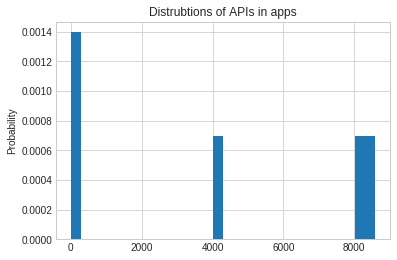

In [18]:
plt.hist(average_apps, normed=True, bins=30)
plt.ylabel('Probability');
plt.title('Distrubtions of APIs in apps')
plt.savefig('app_ap')

In [19]:
## Top 10 Most common Libraries
list_lib_10 = sorted(package_dic, key=lambda k: len(package_dic[k]), reverse=True)[:8]
[print(i, "-",len(package_dic[i])) for i in list_lib_10]
print('')



Landroid/view/View - 177
Landroid/support/v4/app/Fragment - 140
Landroid/support/v4/view/ViewPager - 135
Landroid/view/accessibility/AccessibilityNodeInfo - 97
Landroid/support/v4/app/FragmentManagerImpl - 91
Landroid/support/v4/widget/NestedScrollView - 88
Landroid/support/v4/widget/DrawerLayout - 83
Landroid/support/v4/widget/SwipeRefreshLayout - 72



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


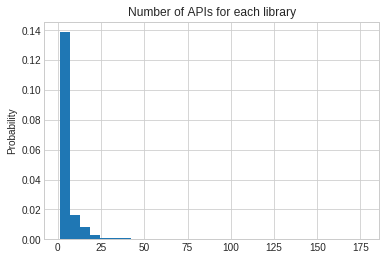

In [20]:
lib_count = [len(set(package_dic[key])) for key in package_dic.keys()]
plt.hist(lib_count, normed=True, bins=30)
plt.ylabel('Probability');
plt.title('Number of APIs for each library')
plt.savefig('lib_plot')

In [21]:
## Top 10 highest occuring API's in codeblocks

code_block_10 = sorted(code_block_dic, key=lambda k: len(code_block_dic[k]), reverse=True)[:10]

[print(i, '-', len(code_block_dic[i])) for i in code_block_10]
print(' ')

Ljava/lang/StringBuilder;->toString() - 1007
Ljava/lang/StringBuilder;-><init>() - 817
Ljava/util/ArrayList;-><init>() - 591
Ljava/lang/StringBuilder;->append() - 589
Ljava/lang/IllegalStateException;-><init>() - 516
Ljava/util/ArrayList;->size() - 452
Lcom/google/android/gms/common/internal/safeparcel/zzb;->zza() - 413
Ljava/lang/Object;-><init>() - 395
Ljava/util/Iterator;->next() - 394
Landroid/util/Log;->e() - 343
 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


Text(0.5, 1.0, 'Number of APIs for each code block')

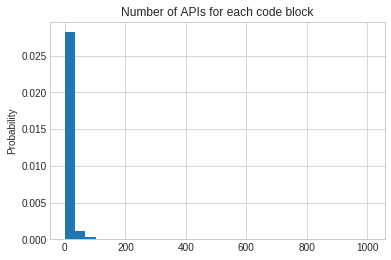

In [22]:
block_count = [len(code_block_dic[key]) for key in code_block_dic.keys()]
plt.hist(block_count, normed=True, bins=30)
plt.ylabel('Probability');
plt.title('Number of APIs for each code block')